## Yield Spread Model 


This notebook implements the model to predict the yield spread using the reference data and trade history

In [1]:
import pandas as pd
import numpy as np

from google.cloud import bigquery
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle

from data_preparation import process_data  

from lightgbm import LGBMRegressor
import lightgbm


from IPython.display import display, HTML

Setting the seed for layer initializer

In [2]:
layer_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=10)

Setting up the credentials for GCP

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../eng-reactor-287421-112eb767e1b3.json"

In [4]:
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

Initializing the big query client

In [5]:
bq_client = bigquery.Client()

Checking if GPU is available

In [6]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

#### Hyper-parameters for the model

The batch size and learning rate have an impact on the smoothness of convergence of the model.\
Larger the batch size the smoother the convergence. For a larger batch size we need a higher learning rate and vice-versa

In [7]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.001
BATCH_SIZE = 10000
NUM_EPOCHS = 100

DROPOUT_RATE = 0.01
NUM_HEADS = 25
TIME2VEC_DIMENSION = 10
FF_DIM = 200

SEQUENCE_LENGTH = 5
NUM_FEATURES = 5

### Query to fetch data from BigQuery

The SQL query uses the trade history with reference data view. All three trade directions, namely dealer-dealer (D), dealer-sells (S), and dealer-purchases (P) are included. We are limiting the training to only tax exempt bonds which have a rating available and the yield is a positive number less than three.  


In [8]:
DATA_QUERY = """ SELECT
  *
FROM
  `eng-reactor-287421.primary_views.trade_history_for_training`
WHERE
  yield IS NOT NULL
  AND yield > 0 
  AND yield <= 3 
  AND par_traded IS NOT NULL
  AND sp_long IS NOT NULL
  AND sp_long != "NR"
  AND trade_date >= '2021-08-01' 
  AND trade_date <= '2021-09-20'
  AND msrb_valid_to_date > current_date -- condition to remove cancelled trades
ORDER BY
  trade_date DESC
            """

### Data Preparation

We grab the data from BigQuery and converts it into a format suitable for input to the model. The fetch_data function uses the big query functionality to return the data from the SQL query as a dataframe. 

In [9]:
%%time
reference_data = process_data(DATA_QUERY, 
                              bq_client,
                              SEQUENCE_LENGTH,
                              NUM_FEATURES,
                              'temp.pkl')

Grabbing yield curve params
Fetching data
Running query
Saving data
Dropping empty trades
Dropping trades less that 10000$
Creating trade history


 47%|████▋     | 156712/330620 [19:13<20:25, 141.97it/s]

Negative seconds ago


 51%|█████     | 167989/330620 [20:35<20:08, 134.58it/s]

Negative seconds ago


 63%|██████▎   | 208253/330620 [25:30<14:44, 138.33it/s]

Negative seconds ago


 63%|██████▎   | 209093/330620 [25:37<15:11, 133.26it/s]

Negative seconds ago


 63%|██████▎   | 209629/330620 [25:41<14:24, 139.98it/s]

Negative seconds ago


100%|██████████| 330620/330620 [40:27<00:00, 136.22it/s]


Trade history created
Data fetched
Padding history
Padding completed
Length before removing Nulls:330620
Length after removing Nulls:322357
Number of samples 322357
CPU times: user 51min 23s, sys: 1min 50s, total: 53min 14s
Wall time: 53min 37s


We use the dictionary to map the interest payment frequency code.

In [31]:
# reference_data.to_pickle('temp_ref.pkl')

In [9]:
reference_data = pd.read_pickle('temp_ref.pkl')

In [10]:
COUPON_FREQUENCY_DICT = {0:"Unknown",
                        1:"Semiannually",
                        2:"Monthly",
                        3:"Annually",
                        4:"Weekly",
                        5:"Quarterly",
                        6:"Every 2 years",
                        7:"Every 3 years",
                        8:"Every 4 years",
                        9:"Every 5 years",
                        10:"Every 7 years",
                        11:"Every 8 years",
                        12:"Biweekly",
                        13:"Changeable",
                        14:"Daily",
                        15:"Term mode",
                        16:"Interest at maturity",
                        17:"Bimonthly",
                        18:"Every 13 weeks",
                        19:"Irregular",
                        20:"Every 28 days",
                        21:"Every 35 days",
                        22:"Every 26 weeks",
                        23:"Not Applicable",
                        24:"Tied to prime",
                        25:"One time",
                        26:"Every 10 years",
                        27:"Frequency to be determined",
                        28:"Mandatory put",
                        29:"Every 52 weeks",
                        30:"When interest adjusts-commercial paper",
                        31:"Zero coupon",
                        32:"Certain years only",
                        33:"Under certain circumstances",
                        34:"Every 15 years",
                        35:"Custom",
                        36:"Single Interest Payment"
                        }

In [25]:
df = reference_data.copy()
df.interest_payment_frequency.fillna(0, inplace=True)
df.interest_payment_frequency = df.interest_payment_frequency.apply(lambda x: COUPON_FREQUENCY_DICT[x])
df.interest_payment_frequency.head()

0            Semiannually
2            Semiannually
4            Semiannually
5    Interest at maturity
6            Semiannually
Name: interest_payment_frequency, dtype: object

Removing trades with size less that 10,000 dollars

In [26]:
df = df[df.par_traded > 10000]
print(len(df))

322357


In [27]:
df['quantity'] = np.log10(df.par_traded.astype(float))
df.coupon = df.coupon.astype(float)
df.issue_amount = np.log10(df.issue_amount)

Dropping a few columns that we do not use as features

In [28]:
%%time
df.drop(columns=[
                 'sp_stand_alone',
                 'sp_icr_school',
                 'sp_icr_school',
                 'sp_icr_school',
                 'sp_watch_long',
                 'sp_outlook_long',
                 'sp_prelim_long',
                 'MSRB_maturity_date',
                 'MSRB_INST_ORDR_DESC',
                 'MSRB_valid_from_date',
                 'MSRB_valid_to_date',
                 'upload_date',
                 'sequence_number',
                 'security_description',
                 'ref_valid_from_date',
                 'ref_valid_to_date',
                 'additional_next_sink_date',
                 'first_coupon_date',
                 'last_period_accrues_from_date',
                 'primary_market_settlement_date',
                 'assumed_settlement_date',
                 'sale_date','q','d'],
                  inplace=True)

CPU times: user 175 ms, sys: 67.6 ms, total: 242 ms
Wall time: 241 ms


Converting the columns to correct datatypes. We also restrict the universe of trades to only investment grade bonds 

In [29]:
%%time

df = df.copy()
date_cols = [col for col in list(df.columns) if 'DATE' in col.upper()]
for col in date_cols:
    df[col] = pd.to_datetime(df[col])

    
prices = ['coupon', 'par_traded', 'dollar_price', 'next_call_price', 'par_call_price', 'refund_price']
for col in prices:
    df[col] = df[col].astype(float)
    
# Just including investment grade bonds
# df = df[df.sp_long.isin(['AAA','AA+','AA','AA-'])] 
df = df[df.sp_long.isin(['A-','A','A+','AA-','AA','AA+','AAA'])] 
df['rating'] = df.sp_long
# df['yield_spread'] = df['yield_spread'] * 100


CPU times: user 2.16 s, sys: 491 ms, total: 2.65 s
Wall time: 2.65 s


Creating Binary features

In [30]:
df['callable'] = df.is_callable  
df['called'] = df.is_called 
df['zerocoupon'] = df.coupon == 0
df['whenissued'] = df.delivery_date >= df.trade_date
df['sinking'] = ~df.next_sink_date.isnull()
df['deferred'] = (df.interest_payment_frequency == 'Unknown') | df.zerocoupon



# if the redemption type is NA we fill it with zero i.e unknown ref ice
df.called_redemption_type.fillna(0, inplace=True)

Converting the dates to number of days from settlement date. We only consider trades to be reportedly correctly if the trades are settled within on month of the trade date. 

In [31]:
# Dropping trades settled one month after the trade
print(len(df))
df['days_to_settle'] = (df.settlement_date - df.trade_date).dt.days
df = df[df.days_to_settle <= 31]
print(len(df))

309828
309218


In [32]:
df['days_to_maturity'] =  np.log10(1 + (df.maturity_date - df.settlement_date).dt.days)
df['days_to_call'] = np.log10(1 + (df.next_call_date - df.settlement_date).dt.days.fillna(0))
df['days_to_refund'] = np.log10(1 + (df.refund_date - df.settlement_date).dt.days)
df['days_to_par'] = np.log10(1 + (df.par_call_date - df.settlement_date).dt.days)
df['call_to_maturity'] = np.log10(1 + (df.maturity_date - df.next_call_date).dt.days)


# # Removing trades which mature in less than a year or 
# # have a call date less than a year from settlement date 

# Removing bonds from Puerto Rico
df = df[df.incorporated_state_code != 'PR']

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


We use the time between the date on which the trade was initiated and the date on which it was settled to create a categorical feature. If the trade is settled within three days from being initiated we consider it to be settled fast. If it is between three and fifteen days we consider the settlement pace to be medium and any trade settled after fifteen days is considered to be slow

In [33]:
def settlement_pace(x):
    if x <= 3:
        return 'Fast'
    elif x>3 and x <=15:
        return 'Medium'
    else:
        return 'Slow'

In [34]:
df['settle_pace'] = df.days_to_settle.apply(settlement_pace)

We drop the trades which have already been called

In [35]:
print(len(df))
# df = df[~df.called]
# print(len(df))

309029


In [36]:
def get_latest_trade_feature(x, feature):
    recent_trade = x[0]
    if feature == 'yield_spread':
        return recent_trade[0]
    elif feature == 'seconds_ago':
        return recent_trade[-1]
    elif feature == 'par_traded':
        return recent_trade[1]

In [37]:
df['last_seconds_ago'] = df.trade_history.apply(get_latest_trade_feature, args=["seconds_ago"])
df['last_yield_spread'] = df.trade_history.apply(get_latest_trade_feature, args=["yield_spread"])
df['last_size'] = df.trade_history.apply(get_latest_trade_feature, args=["par_traded"])
df.head()

,rtrs_control_number,trade_datetime,cusip,my_price,price_delta,msrb_cusip,yield_spread,num_prev_messages,publish_datetime,trade_type,...,days_to_settle,days_to_maturity,days_to_call,days_to_refund,days_to_par,call_to_maturity,settle_pace,last_seconds_ago,last_yield_spread,last_size
0,2021092001501700,2021-09-20 11:24:25,649791GC8,100.848,0.000,649791GC8,-31.871976,0,2021-09-20 11:24:59,D,...,2,3.421933,1.929419,1.929419,1.929419,3.407901,Fast,15.191382,-35.161278,50.0
2,2021092005019100,2021-09-20 15:41:41,74152AAM0,110.771,0.002,74152AAM0,-16.839842,0,2021-09-20 15:42:55,S,...,2,3.727216,3.311330,NaN,3.311330,3.517064,Fast,6.448889,1.260158,410.0
4,2021092000772300,2021-09-20 10:25:56,495260H53,123.636,0.000,495260H53,3.741359,0,2021-09-20 10:26:29,D,...,2,3.476107,3.317854,NaN,3.317854,2.961421,Fast,15.337508,3.611699,15.0
6,2021092003335800,2021-09-20 13:38:53,341507Q87,121.470,0.001,341507Q87,2.302746,0,2021-09-20 13:39:43,S,...,2,3.241546,0.000000,NaN,NaN,NaN,Fast,12.758126,2.920380,35.0
7,2021092000028300,2021-09-20 07:58:38,64971WJ35,100.880,0.000,64971WJ35,15.647435,0,2021-09-20 07:59:27,S,...,2,2.346353,0.000000,NaN,NaN,NaN,Fast,12.425321,27.335342,115.0


Filling missing values for non-categorical features

In [38]:
df.dropna(subset=['instrument_primary_name'], inplace=True)
df.purpose_sub_class.fillna(1,inplace=True)
df.call_timing.fillna(0, inplace=True) #Unknown
df.call_timing_in_part.fillna(0, inplace=True) #Unknown
df.sink_frequency.fillna(10, inplace=True) #Under special circumstances
df.sink_amount_type.fillna(0, inplace=True)
df.issue_text.fillna('No issue text', inplace=True)
df.state_tax_status.fillna(0, inplace=True)
df.series_name.fillna('No series name', inplace=True)

Filling missing values for categorical features

In [39]:
df.next_call_price.fillna(100, inplace=True)
df.par_call_price.fillna(100, inplace=True)
df.min_amount_outstanding.fillna(0, inplace=True)
df.max_amount_outstanding.fillna(0, inplace=True)
df.call_to_maturity.fillna(0, inplace=True)
df.days_to_par.fillna(0, inplace=True)
df.maturity_amount.fillna(0, inplace=True)
df.issue_price.fillna(df.issue_price.mean(), inplace=True)
df.orig_principal_amount.fillna(df.orig_principal_amount.mean(), inplace=True)
df.original_yield.fillna(0, inplace=True)
df.par_price.fillna(100, inplace=True)

Filing missing values for binary features

In [40]:
    df.extraordinary_make_whole_call.fillna(False, inplace=True)
    df.make_whole_call.fillna(False, inplace=True)
    df.default_indicator.fillna(False, inplace=True)

We train the model on a subset of features. These features are defined below

In [41]:
IDENTIFIERS = ['rtrs_control_number', 'cusip']


BINARY = ['callable',
          'sinking',
          'zerocoupon',
          'is_non_transaction_based_compensation',
          'is_general_obligation']


CATEGORICAL_FEATURES = ['rating',
                        'incorporated_state_code',
                        'settle_pace',
                        'trade_type']

NON_CAT_FEATURES = ['quantity',
                    'days_to_maturity',
                    'days_to_call',
                    'coupon',
                    'issue_amount',
                    'last_seconds_ago',
                    'last_yield_spread',]
                    #'last_size']

NON_CAT_FEATURES += ['days_to_settle',
                     'days_to_par',
                     'maturity_amount',
                     'issue_price', 
                     'orig_principal_amount',
                     'max_amount_outstanding']

BINARY += ['callable_at_cav',           
           'extraordinary_make_whole_call', 
           'make_whole_call',
           'has_unexpired_lines_of_credit',
           'escrow_exists',
          ]


CATEGORICAL_FEATURES += ['transaction_type','maturity_description_code','purpose_class']

TRADE_HISTORY = ['trade_history']
TARGET = ['yield_spread']

PREDICTORS = BINARY + CATEGORICAL_FEATURES + NON_CAT_FEATURES + TARGET + TRADE_HISTORY

In [42]:
processed_data = df[IDENTIFIERS + PREDICTORS]

In [44]:
processed_data.maturity_amount = np.log10(1 + processed_data.maturity_amount)
processed_data.orig_principal_amount = np.log10(1 + processed_data.orig_principal_amount)
processed_data.max_amount_outstanding = np.log10(1 + processed_data.max_amount_outstanding)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [45]:
for col in NON_CAT_FEATURES:
    processed_data[col] = processed_data[col].astype(float)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
processed_data = processed_data.dropna()
len(processed_data)

309003

In [47]:
# print(len(processed_data))
# processed_data = processed_data[~(processed_data.rating == 'AA') ]
# # processed_data = processed_data[~(processed_data.whenissued == True) ]
# print(len(processed_data))

Splitting the date into train and test set

In [48]:
train_index = int( len(processed_data) * (1-TRAIN_TEST_SPLIT))
train_dataframe = processed_data[train_index:]
test_dataframe = processed_data[:train_index]

print(len(train_dataframe))
print(len(test_dataframe))


262653
46350


## Combining the pre-trained models

### Loading trade history model

In [76]:
trade_history_model = keras.models.load_model("trade_history_aug")

Removing the last layer

In [77]:
trade_history_model = keras.Model(trade_history_model.input, trade_history_model.layers[-2].output)
# trade_history_model.summary()

### Loading the reference data model

In [78]:
reference_data_model = keras.models.load_model("reference_data_aug")

Removing the last layer

In [79]:
reference_data_model = keras.Model(reference_data_model.input, reference_data_model.layers[-2].output)
#reference_data_model.summary()

In [80]:
encoders = {}
for f in CATEGORICAL_FEATURES:
    fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep

In [81]:
def create_input(df):
    datalist = []
    for f in NON_CAT_FEATURES + BINARY:
        datalist.append(df[f].to_numpy().astype('float64'))
        
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float64'))
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    return datalist

Mergning the models

In [82]:
feed_forward_input = layers.concatenate([reference_data_model.output, trade_history_model.output],name="Concatinating_outputs")

hidden = layers.Dense(300, 
                      activation='relu',
                      kernel_initializer=layer_initializer,
                      name = 'Output_block_layer1')(feed_forward_input)

hidden2 = layers.Dense(150,
                       activation='relu',
                       kernel_initializer=layer_initializer,
                       name = 'Output_block_layer2')(hidden)

final = layers.Dense(1,
                     kernel_initializer=layer_initializer,
                     name = 'Output_block_layer3')(hidden2)

inputs = reference_data_model.input + [trade_history_model.input]


model = keras.Model(inputs=inputs, outputs=final)

In [83]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rating (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
incorporated_state_code (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
settle_pace (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
trade_type (InputLayer)         [(None, 1)]          0                                            
____________________________________________________________________________________________

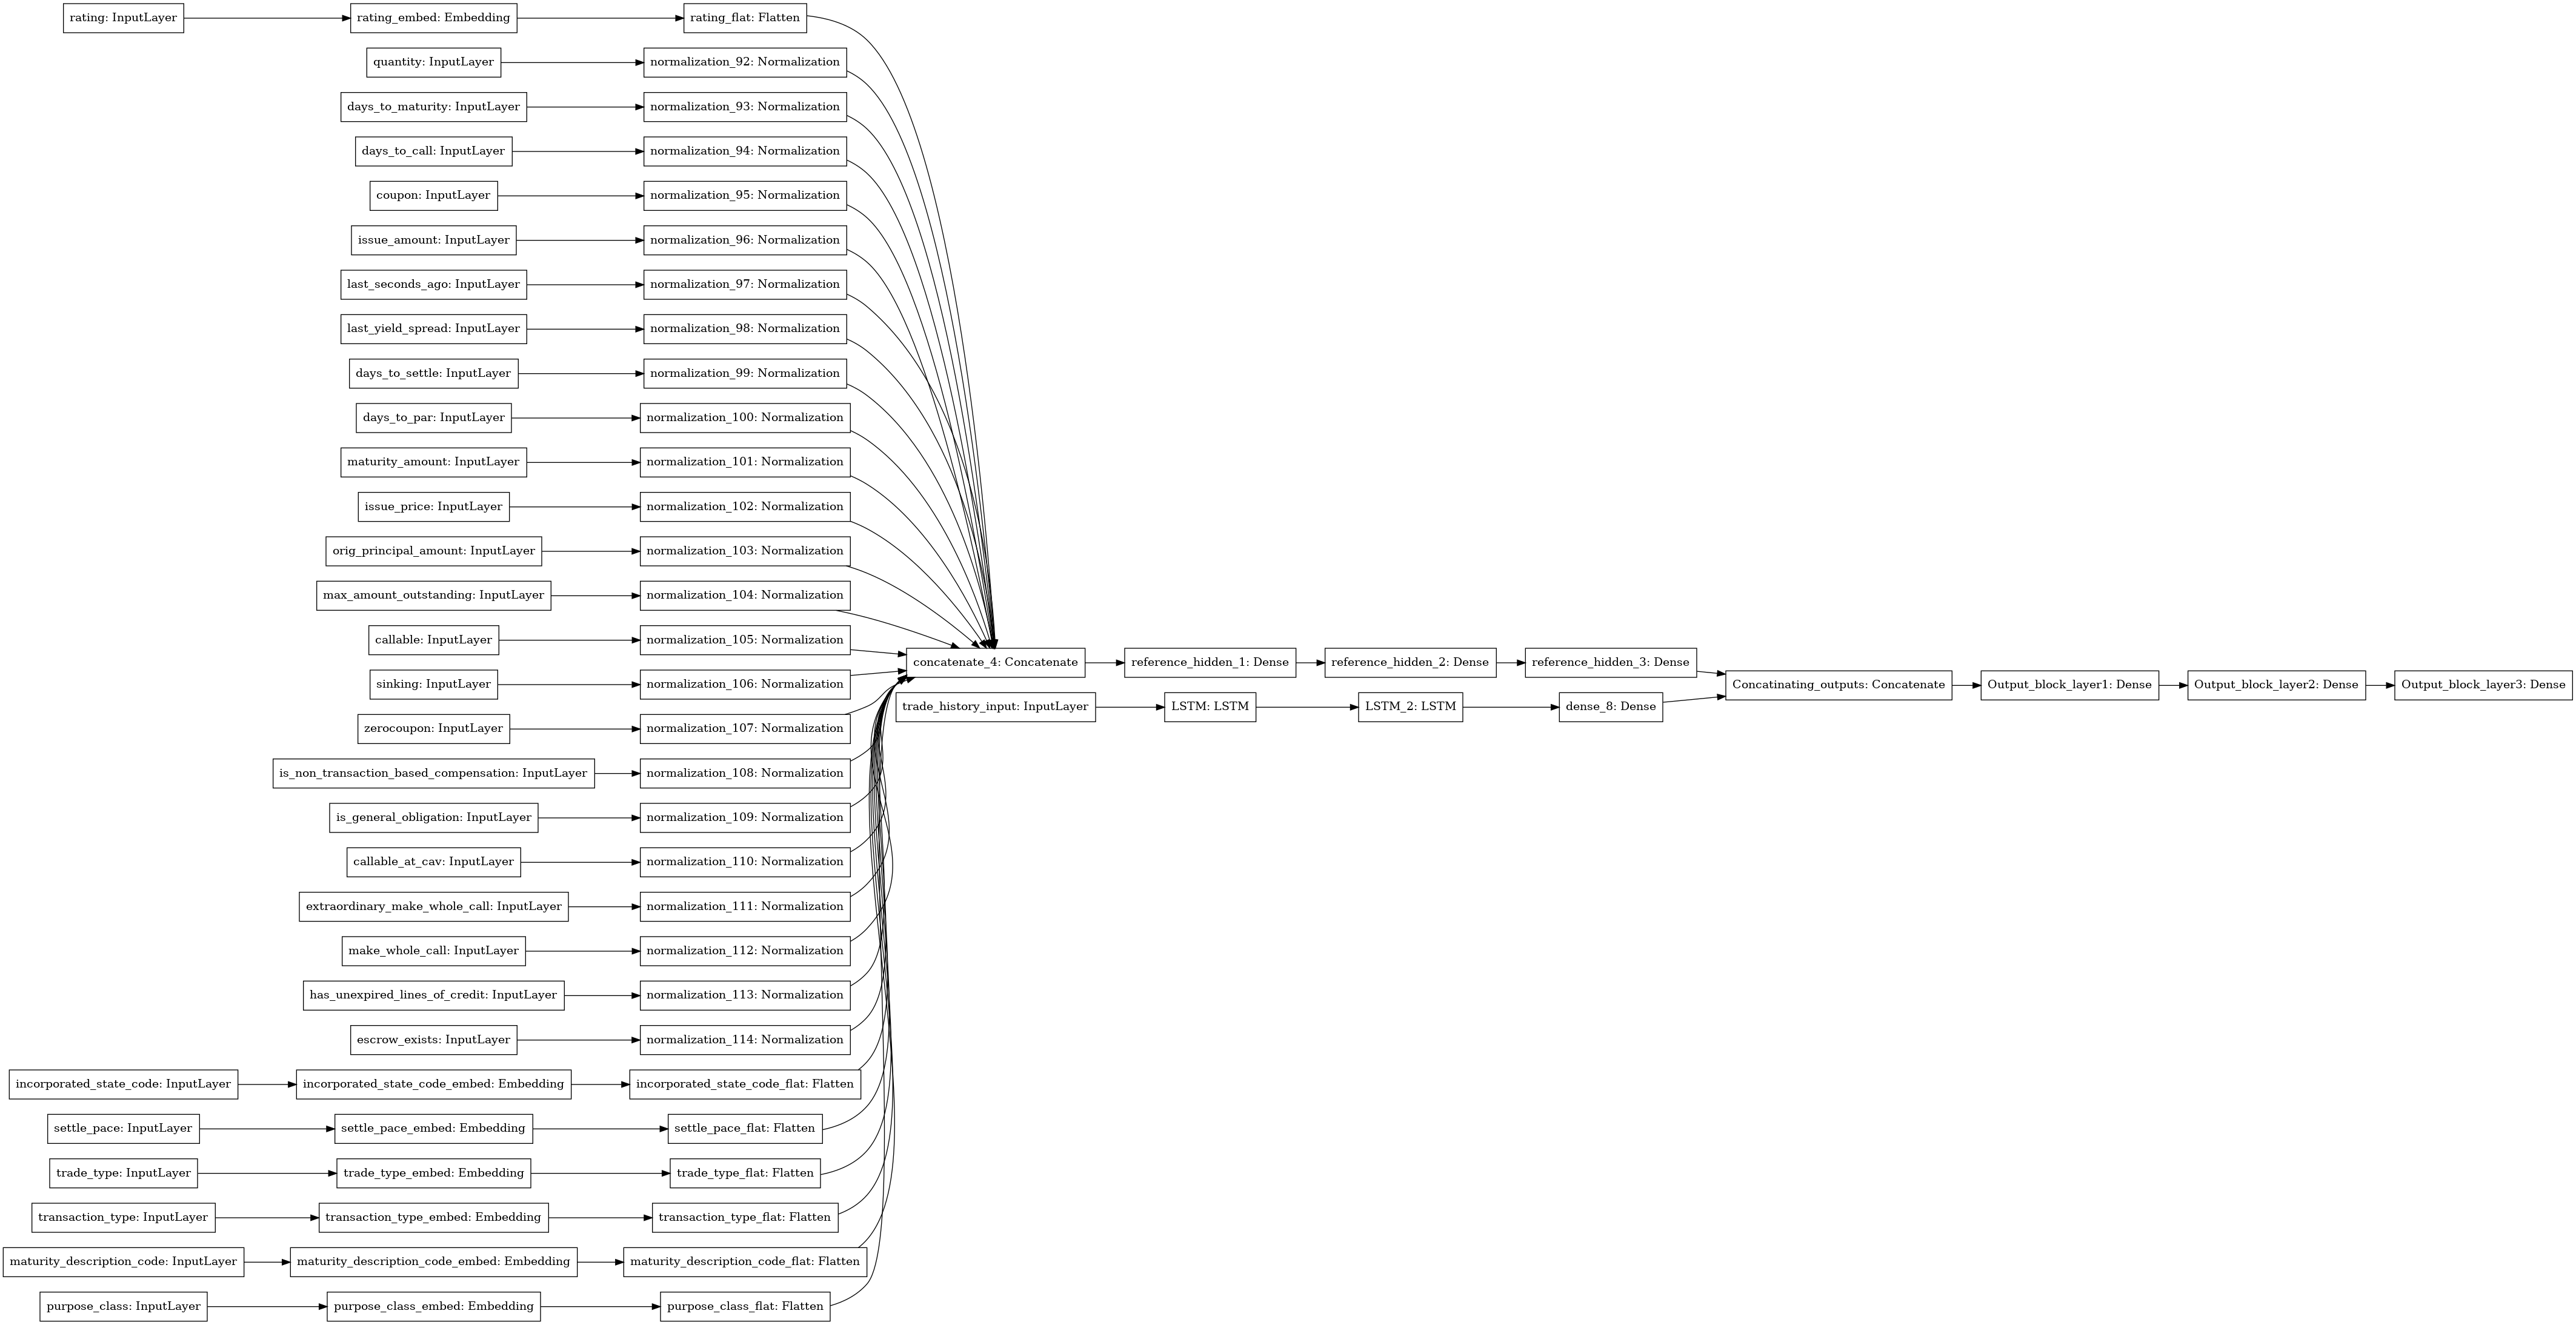

In [84]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [85]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [86]:
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 10,
                                                 profile_batch = '500,520')

In [87]:
train_data = create_input(train_dataframe)
%time history = model.fit(train_data, train_dataframe.yield_spread, epochs=50, batch_size=1000, verbose=1, validation_split=0.1, callbacks = [tboard_callback])

Epoch 1/50
237/237 [==============================] - 7s 14ms/step - loss: 264.0932 - mean_absolute_error: 10.1697 - val_loss: 260.1011 - val_mean_absolute_error: 9.8303
Epoch 2/50
237/237 [==============================] - 2s 9ms/step - loss: 224.8343 - mean_absolute_error: 9.3874 - val_loss: 264.2612 - val_mean_absolute_error: 9.8929
Epoch 3/50
237/237 [==============================] - 4s 17ms/step - loss: 220.9379 - mean_absolute_error: 9.3209 - val_loss: 313.0208 - val_mean_absolute_error: 11.5065
Epoch 4/50
237/237 [==============================] - 2s 9ms/step - loss: 220.2642 - mean_absolute_error: 9.3211 - val_loss: 278.5130 - val_mean_absolute_error: 10.3374
Epoch 5/50
237/237 [==============================] - 2s 9ms/step - loss: 218.0775 - mean_absolute_error: 9.3037 - val_loss: 280.0223 - val_mean_absolute_error: 10.4240
Epoch 6/50
237/237 [==============================] - 2s 10ms/step - loss: 214.0594 - mean_absolute_error: 9.2209 - val_loss: 268.4398 - val_mean_absolute

In [88]:
_, mae = model.evaluate(create_input(test_dataframe), test_dataframe.yield_spread, verbose=1)
print(f"Test MAE: {round(mae, 3)}")

1449/1449 [==============================] - 7s 5ms/step - loss: 275.2891 - mean_absolute_error: 9.3714
Test MAE: 9.371


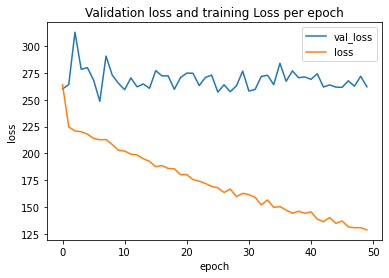

In [89]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [90]:
model.save('yield_spread_combined_aug/')

INFO:tensorflow:Assets written to: yield_spread_combined_aug/assets


INFO:tensorflow:Assets written to: yield_spread_combined_aug/assets


In [71]:
encarray = create_input(train_dataframe)
%time preds = model.predict(encarray)
preds = preds.reshape(len(preds))

error = train_dataframe.yield_spread - preds

CPU times: user 51.8 s, sys: 10.4 s, total: 1min 2s
Wall time: 28.6 s


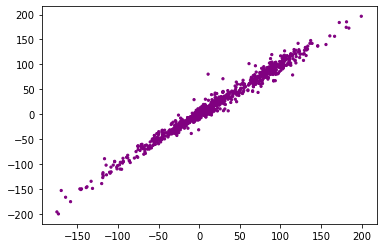

In [72]:
from matplotlib.colors import to_rgb, to_rgba
threshold = 1e6

# plot points with transparency depending on size of trade
def drawpoints(preds, target, train_dataframe):
    #Only draw Dealer-Dealer trades
    r, g, b = to_rgb('purple')
    keep = (10**train_dataframe.quantity > threshold) & (train_dataframe.trade_type == 'D')  # save time by not plotting points that would be invisible
    w = np.minimum( np.array(10**train_dataframe.quantity[keep]), threshold)
    opacity = w/threshold
    color = [(r, g, b, alpha) for alpha in opacity]
    plt.scatter(preds[keep], target[keep], s=5, c=color)
    
plt.figure()
drawpoints(preds, train_dataframe.yield_spread, train_dataframe)

In [73]:
test_preds = model.predict(create_input(test_dataframe))

In [74]:
test_temp = df[df.index.isin(test_dataframe.index)]

In [62]:
evaluation_dataframe = test_temp.copy()
evaluation_dataframe['predicted_yield_spreads'] = test_preds
evaluation_dataframe['delta_yield_spreads'] = evaluation_dataframe.yield_spread - evaluation_dataframe.predicted_yield_spreads

In [63]:
evaluation_dataframe.days_to_maturity = 10**evaluation_dataframe.days_to_maturity
evaluation_dataframe.days_to_call = 10**evaluation_dataframe.days_to_call
evaluation_dataframe.quantity = 10**evaluation_dataframe.quantity
evaluation_dataframe.sort_values('delta_yield_spreads', ascending=False)

,rtrs_control_number,trade_datetime,cusip,my_price,price_delta,msrb_cusip,yield_spread,num_prev_messages,publish_datetime,trade_type,...,days_to_call,days_to_refund,days_to_par,call_to_maturity,settle_pace,last_seconds_ago,last_yield_spread,last_size,predicted_yield_spreads,delta_yield_spreads
124179,2021081701937500,2021-08-17 11:35:05,545904KD5,100.002,0.002,545904KD5,261.113970,0,2021-08-17 11:36:28,P,...,31.0,1.556303,1.491362,3.195346,Fast,16.391561,-35.487201,10.0,-14.486783,275.600753
131550,2021081703083100,2021-08-17 12:49:22,087463DQ5,99.832,0.001,087463DQ5,243.566468,0,2021-08-17 12:49:39,P,...,20.0,NaN,1.301030,3.049606,Fast,15.760730,-2114.352628,25.0,-7.014191,250.580659
129397,2021081703083200,2021-08-17 12:49:22,087463DQ5,99.981,0.000,087463DQ5,238.566468,0,2021-08-17 12:49:55,D,...,20.0,NaN,1.301030,3.049606,Fast,15.760730,-2114.352628,25.0,-7.091131,245.657598
116598,2021081703087500,2021-08-17 12:49:22,087463DQ5,99.981,0.000,087463DQ5,238.566468,0,2021-08-17 12:49:55,S,...,20.0,NaN,1.301030,3.049606,Fast,15.760730,-2114.352628,25.0,-6.524524,245.090992
77501,2021082304710600,2021-08-23 15:08:02,013122SZ0,100.000,0.000,013122SZ0,211.913275,0,2021-08-23 15:09:49,P,...,281.0,2.448706,2.448706,3.562769,Fast,4.779123,-44.186725,30.0,-31.859365,243.772641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104603,2021081804420800,2021-08-18 13:55:22,406684DK3,100.093,0.004,406684DK3,76.811613,0,2021-08-18 13:55:59,P,...,30.0,NaN,1.477121,2.409933,Fast,17.717983,121.675244,20.0,253.275955,-176.464342
116595,2021081706666900,2021-08-17 16:56:23,799017HV3,98.608,0.004,799017HV3,-179.595521,0,2021-08-17 16:56:30,D,...,7319.0,NaN,3.864452,3.261739,Fast,18.200120,-22.378402,250.0,-1.339060,-178.256461
123,2021090106065500,2021-09-01 15:47:18,574328AQ3,100.511,0.000,574328AQ3,-56.005045,0,2021-09-01 15:48:41,S,...,1.0,1.462398,0.000000,0.000000,Fast,8.973985,580.494955,25.0,139.537247,-195.542292
3470,2021090102700100,2021-09-01 12:17:00,13063BJA1,100.885,0.000,13063BJA1,19.712975,0,2021-09-01 12:18:10,P,...,1.0,NaN,0.000000,0.000000,Fast,11.170703,183.670816,50.0,230.499924,-210.786949


In [64]:
evaluation_dataframe[PREDICTORS + ['maturity_date','trade_date','settlement_date','predicted_yield_spreads','predicted_yield_spreads','predicted_yield_spreads']]

,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,has_unexpired_lines_of_credit,escrow_exists,...,orig_principal_amount,max_amount_outstanding,yield_spread,trade_history,maturity_date,trade_date,settlement_date,predicted_yield_spreads,predicted_yield_spreads,predicted_yield_spreads
0,False,True,False,False,False,False,True,True,False,False,...,65020000.0,65020000.0,146.099144,"[[166.1516500378803, 5.0, 0.0, 0.0, 12.9748976...",2032-11-15,2021-09-01,2021-09-03,151.145828,151.145828,151.145828
1,False,False,False,False,False,False,False,False,False,False,...,4370000.0,4370000.0,5.136231,"[[17.35289599573332, 15.0, 0.0, 0.0, 12.031951...",2024-06-01,2021-09-01,2021-09-03,3.445081,3.445081,3.445081
2,False,False,False,False,False,False,False,False,False,True,...,11955000.0,11955000.0,-51.210507,"[[-40.998668846350874, 15.0, 1.0, 0.0, 12.0424...",2032-11-01,2021-09-01,2021-09-03,-50.282497,-50.282497,-50.282497
4,False,False,False,False,False,False,False,False,False,False,...,7700000.0,7700000.0,5.491906,"[[17.63298865183366, 130.0, 0.0, 0.0, 13.12986...",2022-07-01,2021-09-01,2021-09-03,16.948503,16.948503,16.948503
5,True,False,False,False,False,False,False,False,False,False,...,4000000.0,4000000.0,7.741212,"[[123.54121158237469, 70.0, 1.0, 0.0, 9.053218...",2023-04-01,2021-09-01,2021-09-03,33.722069,33.722069,33.722069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168109,True,False,False,False,False,False,False,False,False,False,...,49765000.0,49765000.0,17.471551,"[[38.36513715037146, 15.0, 1.0, 0.0, 11.096515...",2023-04-01,2021-08-12,2021-08-16,12.159636,12.159636,12.159636
168110,False,False,False,False,False,False,False,False,False,False,...,17180000.0,17180000.0,49.084714,"[[30.9503969612331, 15.0, 0.0, 1.0, 14.2074587...",2021-11-01,2021-08-12,2021-08-16,65.296516,65.296516,65.296516
168111,True,False,False,True,False,False,False,False,False,False,...,7350000.0,7350000.0,54.188865,"[[16.688864735339877, 100.0, 0.0, 1.0, 9.19054...",2027-10-01,2021-08-12,2021-08-16,53.458473,53.458473,53.458473
168112,False,False,False,False,True,False,False,False,False,False,...,3030000.0,3030000.0,13.744700,"[[20.14469960378909, 50.0, 1.0, 0.0, 8.1318247...",2023-05-01,2021-08-12,2021-08-16,15.043334,15.043334,15.043334


In [65]:
temp = evaluation_dataframe[(evaluation_dataframe.delta_yield_spreads < 3) & (evaluation_dataframe.delta_yield_spreads > -3)  ]
temp.sort_values('delta_yield_spreads',ascending=False)
display(temp)
temp.to_csv('less_than_3.csv',index=False)

,rtrs_control_number,trade_datetime,cusip,my_price,price_delta,msrb_cusip,yield_spread,num_prev_messages,publish_datetime,trade_type,...,days_to_call,days_to_refund,days_to_par,call_to_maturity,settle_pace,last_seconds_ago,last_yield_spread,last_size,predicted_yield_spreads,delta_yield_spreads
1,2021090100660300,2021-09-01 09:47:09,93974D7E2,112.865,0.000,93974D7E2,5.136231,0,2021-09-01 09:49:01,S,...,1.0,NaN,0.000000,0.000000,Fast,12.031951,17.352896,15.0,3.445081,1.691150
2,2021090100790600,2021-09-01 09:55:54,914440QG0,118.872,0.000,914440QG0,-51.210507,0,2021-09-01 09:56:20,S,...,1521.0,3.182129,3.182129,3.407901,Fast,12.042447,-40.998669,15.0,-50.282497,-0.928010
16,2021090103484400,2021-09-01 13:02:05,63165TPA7,111.631,0.001,63165TPA7,5.702730,0,2021-09-01 13:02:22,P,...,942.0,2.974051,2.974051,2.863917,Fast,12.017113,3.682998,15.0,6.281658,-0.578927
17,2021090104801700,2021-09-01 14:26:50,914391X51,102.594,0.001,914391X51,23.931105,0,2021-09-01 14:27:08,S,...,2921.0,NaN,3.465532,3.766785,Fast,2.639057,23.931105,300.0,22.601080,1.330025
20,2021090100717800,2021-09-01 09:50:42,680799DC4,108.325,0.001,680799DC4,6.727685,0,2021-09-01 09:51:43,S,...,1.0,NaN,0.000000,0.000000,Fast,12.032368,-3.055093,275.0,7.452579,-0.724895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168072,2021081202561100,2021-08-12 12:17:45,419792VZ6,115.205,0.000,419792VZ6,18.504597,0,2021-08-12 12:17:58,P,...,1.0,NaN,0.000000,0.000000,Medium,13.145500,12.344484,10.0,20.702757,-2.198160
168082,2021081204299100,2021-08-12 14:19:26,89952PEJ0,109.344,0.001,89952PEJ0,7.271773,0,2021-08-12 14:19:44,D,...,747.0,NaN,2.873321,2.864511,Medium,14.205106,23.995764,40.0,6.717334,0.554439
168106,2021081204904600,2021-08-12 15:08:31,082850AY4,116.552,0.002,082850AY4,36.557743,0,2021-08-12 15:08:40,P,...,1.0,NaN,0.000000,0.000000,Medium,5.389072,32.157743,35.0,38.596432,-2.038689
168111,2021081204300200,2021-08-12 14:19:31,010869GM1,104.097,0.001,010869GM1,54.188865,0,2021-08-12 14:19:44,P,...,777.0,NaN,2.890421,3.164947,Medium,9.190546,16.688865,100.0,53.458473,0.730392


In [66]:
temp = evaluation_dataframe[(evaluation_dataframe.delta_yield_spreads > 50) | (evaluation_dataframe.delta_yield_spreads < -50)  ]
temp = temp.sort_values('delta_yield_spreads',ascending=False)
display(temp)
temp.to_csv('Greater_than_50.csv',index=False)

,rtrs_control_number,trade_datetime,cusip,my_price,price_delta,msrb_cusip,yield_spread,num_prev_messages,publish_datetime,trade_type,...,days_to_call,days_to_refund,days_to_par,call_to_maturity,settle_pace,last_seconds_ago,last_yield_spread,last_size,predicted_yield_spreads,delta_yield_spreads
124179,2021081701937500,2021-08-17 11:35:05,545904KD5,100.002,0.002,545904KD5,261.113970,0,2021-08-17 11:36:28,P,...,31.0,1.556303,1.491362,3.195346,Fast,16.391561,-35.487201,10.0,-14.486783,275.600753
131550,2021081703083100,2021-08-17 12:49:22,087463DQ5,99.832,0.001,087463DQ5,243.566468,0,2021-08-17 12:49:39,P,...,20.0,NaN,1.301030,3.049606,Fast,15.760730,-2114.352628,25.0,-7.014191,250.580659
129397,2021081703083200,2021-08-17 12:49:22,087463DQ5,99.981,0.000,087463DQ5,238.566468,0,2021-08-17 12:49:55,D,...,20.0,NaN,1.301030,3.049606,Fast,15.760730,-2114.352628,25.0,-7.091131,245.657598
116598,2021081703087500,2021-08-17 12:49:22,087463DQ5,99.981,0.000,087463DQ5,238.566468,0,2021-08-17 12:49:55,S,...,20.0,NaN,1.301030,3.049606,Fast,15.760730,-2114.352628,25.0,-6.524524,245.090992
77501,2021082304710600,2021-08-23 15:08:02,013122SZ0,100.000,0.000,013122SZ0,211.913275,0,2021-08-23 15:09:49,P,...,281.0,2.448706,2.448706,3.562769,Fast,4.779123,-44.186725,30.0,-31.859365,243.772641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104603,2021081804420800,2021-08-18 13:55:22,406684DK3,100.093,0.004,406684DK3,76.811613,0,2021-08-18 13:55:59,P,...,30.0,NaN,1.477121,2.409933,Fast,17.717983,121.675244,20.0,253.275955,-176.464342
116595,2021081706666900,2021-08-17 16:56:23,799017HV3,98.608,0.004,799017HV3,-179.595521,0,2021-08-17 16:56:30,D,...,7319.0,NaN,3.864452,3.261739,Fast,18.200120,-22.378402,250.0,-1.339060,-178.256461
123,2021090106065500,2021-09-01 15:47:18,574328AQ3,100.511,0.000,574328AQ3,-56.005045,0,2021-09-01 15:48:41,S,...,1.0,1.462398,0.000000,0.000000,Fast,8.973985,580.494955,25.0,139.537247,-195.542292
3470,2021090102700100,2021-09-01 12:17:00,13063BJA1,100.885,0.000,13063BJA1,19.712975,0,2021-09-01 12:18:10,P,...,1.0,NaN,0.000000,0.000000,Fast,11.170703,183.670816,50.0,230.499924,-210.786949


In [112]:
df[df.rtrs_control_number == 2021081701937500][['yield_spread','yield','trade_date','maturity_date']]

,yield_spread,yield,trade_date,maturity_date
124179,261.11397,2.964,2021-08-17,2026-01-01
